# **CS412 - Recitation 9: Sentiment Analysis**

## Overview

In this notebook, we'll study a **classical text classification pipeline** for **sentiment analysis**, using movie reviews from the IMDB dataset.  
The goal is to predict whether a given review expresses a **positive** or **negative** opinion.

We'll focus on traditional machine learning methods, Multinomial Naive Bayes and Logistic Regression to extract meaning from movie reviews.


### Sentiment Analysis

**Sentiment analysis** is the task of automatically identifying the **emotional polarity** of a piece of text.

In its simplest form (which we use here), it is a **binary classification problem**:
- **1** → Positive sentiment  
- **0** → Negative sentiment  

Examples:
- “This movie was fantastic and unforgettable.” → Positive  
- “A boring and disappointing waste of time.” → Negative  



### What is Text Processing?

Unlike numerical data, text is unstructured and cannot be used directly by machine learning algorithms.  
**Text processing** refers to the steps required to convert raw text into a numerical representation that a model can understand and work with.

In this notebook, we apply the following standard preprocessing steps:

1. **Lowercasing**  
   Convert all text to lowercase to avoid treating words like “Good” and “good” as different.

2. **Punctuation and symbol removal**  
   Remove punctuation, numbers, and special characters that usually do not contribute to sentiment.

3. **Tokenization**  
   Split text into individual words (tokens).

4. **Stopword removal**  
   Remove very common words (e.g., *the*, *is*, *and*) that carry little semantic or sentiment information.

After these steps, each review becomes a cleaned sequence of meaningful words.



---

### Multinomial Naive Bayes (MNB)

**Multinomial Naive Bayes (MNB)** is a probabilistic classifier that is particularly well suited for text classification tasks, where documents are represented as word count based feature vectors such as Bag-of-Words or TF-IDF.




#### Model Formulation

Let:
- $d = (w_1, w_2, \dots, w_n)$ be a document represented by its words  
- $y \in \{0, 1\}$ be the class label (negative or positive)

Using Bayes’ rule, the posterior probability of a class given a document is:

$$
P(y \mid d) \propto P(y) \prod_{i=1}^{n} P(w_i \mid y)
$$

where:
- $P(y)$ is the **prior probability** of class $y$
- $P(w_i \mid y)$ is the **class-conditional probability** of word $w_i$

The document is assigned to the class with the highest posterior probability.

---

### From Text to Numbers: Vectorization

Machine learning models require **numerical feature vectors**.  
The process of converting text into numerical form is called **vectorization**.

In this notebook, we use two classical vectorization techniques:


### Bag-of-Words (BoW)

**Bag-of-Words** represents a document by counting how many times each word appears. It is simple, fast and often performs surprisingly well for text classification.
However, there is no notion of meaning or similarity between words.


![Bag-of-Words Example](https://vitalflux.com/wp-content/uploads/2021/08/Bag-of-words-technique-to-convert-to-numerical-feature-vector-png-640x212.png)



### TF-IDF (Term Frequency – Inverse Document Frequency)

**TF-IDF** improves upon the Bag-of-Words representation by reweighting word frequencies instead of relying on raw counts.  
As in Bag-of-Words, each document is represented as a vector over the vocabulary, but the value assigned to each word reflects how informative that word is for a particular document rather than how often it appears alone.

The intuition behind TF-IDF is straightforward:

- Words that appear frequently in a given document are likely to be important for that document.
- However, words that appear frequently across many documents carry little discriminative information and should be downweighted.


#### Mathematical Formulation

For a word $w$ in document $d$, the TF-IDF score is defined as:

$$
\text{TF-IDF}(w, d) = \text{TF}(w, d) \times \text{IDF}(w)
$$

where the term frequency measures how often a word appears in a document:

$$
\text{TF}(w, d) = \frac{\text{count of } w \text{ in } d}{\text{total number of words in } d}
$$

and the inverse document frequency measures how rare a word is across the entire corpus:

$$
\text{IDF}(w) = \log \left( \frac{N}{\text{df}(w)} \right)
$$

Here, $N$ denotes the total number of documents in the corpus, and $\text{df}(w)$ denotes the number of documents in which the word $w$ appears.

Although TF-IDF still ignores word order and context, it often leads to better performance than raw Bag-of-Words by focusing the model’s attention on more informative words.



#### Parameter Estimation (with Laplace Smoothing)

In Multinomial Naive Bayes, the class-conditional word probabilities are estimated from the training data.  
When **Bag-of-Words** features are used, these probabilities are computed from **raw word counts** as:

$$
P(w \mid y) = \frac{N_{w,y} + \alpha}{N_y + \alpha |V|}
$$

where:
- $N_{w,y}$ is the total number of times word $w$ appears in documents of class $y$
- $N_y$ is the total number of word occurrences in class $y$
- $|V|$ is the vocabulary size
- $\alpha > 0$ is the smoothing parameter (typically $\alpha = 1$)

**Laplace smoothing** prevents zero probabilities for words that do not appear in the training documents of a given class.

---

When **TF-IDF** features are used, the estimation procedure remains structurally the same, but the interpretation of the variables changes.  
Instead of raw counts, the model operates on **TF-IDF–weighted frequencies**.

Let $x_{d,w}$ denote the TF-IDF value of word $w$ in document $d$.  
The class-conditional contribution of a word is then computed as:

$$
\tilde{N}_{w,y} = \sum_{d \in y} x_{d,w}
$$

and the total mass for class $y$ becomes:

$$
\tilde{N}_y = \sum_{w \in V} \tilde{N}_{w,y}
$$

The smoothed class-conditional probability is therefore estimated as:

$$
P(w \mid y) = \frac{\tilde{N}_{w,y} + \alpha}{\tilde{N}_y + \alpha |V|}
$$

In this setting, **Laplace smoothing no longer corresponds to adding fake word counts**, but instead acts as a **regularization term** on TF-IDF–weighted feature sums.  


## Code

### Data Load

In [ ]:
# Import necessary tools
import os
import re
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


In [ ]:
# Adjustment to make pandas display DataFrames' full length.
pd.set_option("display.max_colwidth", None)

In [ ]:
# Collect the data text file and read it.
from google.colab import drive
drive.mount('/content/drive')

imdb_txt = "/content/drive/MyDrive/imdb_labelled.txt"

with open(imdb_txt, encoding="utf-8") as f:
    lines = f.readlines()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the data into a dataframe, separate review body and labels.
data = []

for line in lines:
    line = line.strip()
    if not line:
        continue

    try:
        text, label = line.rsplit("\t", 1)
        data.append((text, int(label)))
    except ValueError:
        # In case of malformed lines
        continue

df = pd.DataFrame(data, columns=["text", "label"])

In [ ]:
# Let's see a portion of our data
df.head(5)

,text,label
0,"A very, very, very slow-moving, aimless movie about a distressed, drifting young man.",0
1,"Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.",0
2,"Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.",0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head.,1


### Preprocessing

In [ ]:
# Download required NLTK resources for tokenization and stopword removal
nltk.download("punkt_tab")  # Auxiliary tables used by the Punkt tokenizer
nltk.download("punkt")      # Pretrained model for sentence and word tokenization
nltk.download("stopwords")  # List of common stopwords (e.g., "the", "is", "and")


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# View the stopwords in the NLTK library.
stop_words = stopwords.words("english"),
stop_words

(['a',
  'about',
  'above',
  'after',
  'again',
  'against',
  'ain',
  'all',
  'am',
  'an',
  'and',
  'any',
  'are',
  'aren',
  "aren't",
  'as',
  'at',
  'be',
  'because',
  'been',
  'before',
  'being',
  'below',
  'between',
  'both',
  'but',
  'by',
  'can',
  'couldn',
  "couldn't",
  'd',
  'did',
  'didn',
  "didn't",
  'do',
  'does',
  'doesn',
  "doesn't",
  'doing',
  'don',
  "don't",
  'down',
  'during',
  'each',
  'few',
  'for',
  'from',
  'further',
  'had',
  'hadn',
  "hadn't",
  'has',
  'hasn',
  "hasn't",
  'have',
  'haven',
  "haven't",
  'having',
  'he',
  "he'd",
  "he'll",
  'her',
  'here',
  'hers',
  'herself',
  "he's",
  'him',
  'himself',
  'his',
  'how',
  'i',
  "i'd",
  'if',
  "i'll",
  "i'm",
  'in',
  'into',
  'is',
  'isn',
  "isn't",
  'it',
  "it'd",
  "it'll",
  "it's",
  'its',
  'itself',
  "i've",
  'just',
  'll',
  'm',
  'ma',
  'me',
  'mightn',
  "mightn't",
  'more',
  'most',
  'mustn',
  "mustn't",
  'my',
  'mys

In [ ]:
def preprocess_text(text):
    text = text.lower()                   # Convert text to lowercase
    text = re.sub(r"[^a-z\s]", "", text)  # Remove punctuation and digits
    tokens = word_tokenize(text)          # Tokenize text into words
    tokens = [t for t in tokens if t not in stop_words[0]]  # Remove stopwords
    return " ".join(tokens)               # Reconstruct cleaned text


In [ ]:
df["clean_text"] = df["text"].apply(preprocess_text)
df[["text", "clean_text", "label"]].head(5)

,text,clean_text,label
0,"A very, very, very slow-moving, aimless movie about a distressed, drifting young man.",slowmoving aimless movie distressed drifting young man,0
1,"Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.",sure lost flat characters audience nearly half walked,0
2,"Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.",attempting artiness black white clever camera angles movie disappointed became even ridiculous acting poor plot lines almost nonexistent,0
3,Very little music or anything to speak of.,little music anything speak,0
4,The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head.,best scene movie gerardo trying find song keeps running head,1


### Data Split

In [ ]:
# Split the train and test data after preprocessing
X_train, X_test, y_train, y_test = train_test_split(
    df["clean_text"],
    df["label"],
    test_size=0.2,
    random_state=1312,
    stratify=df["label"]
)

### Multinomial Naive Bayes with BoW

In [ ]:
# Initialize the vectorizer, set a maximum for vocabulary size
bow_vectorizer = CountVectorizer(max_features=10000)

# Learn the vocabulary from the training data and convert
# each training document into a sparse word-count vector.
X_train_bow = bow_vectorizer.fit_transform(X_train)

# Convert the test documents into word-count vectors using
# the same vocabulary learned from the training data.
X_test_bow = bow_vectorizer.transform(X_test)

In [ ]:
vocab = bow_vectorizer.vocabulary_
sorted_vocab = sorted(vocab.items(), key=lambda x: x[1])

print(f"Vocabulary size: {len(bow_vectorizer.vocabulary_)}")
print(f"Shape: {X_train_bow.shape}\n")

# Each word is mapped to a column index
for word, idx in sorted_vocab[:30]:
    print(idx, word)

Vocabulary size: 2639
Shape: (800, 2639)

0 aailiyah
1 abandoned
2 ability
3 abroad
4 absolutely
5 abstruse
6 abysmal
7 academy
8 accessible
9 acclaimed
10 accolades
11 accurate
12 accurately
13 accused
14 achievement
15 achille
16 ackerman
17 act
18 acted
19 acting
20 actingeven
21 actingwise
22 action
23 actor
24 actors
25 actress
26 actresses
27 actually
28 adaptation
29 add


In [ ]:
# Let's see a sample and observe how the BoW vector is constructed:
feature_names = bow_vectorizer.get_feature_names_out()

doc_id = 23  # pick any training document
doc_vector = X_train_bow[doc_id]

indices = doc_vector.nonzero()[1]
counts = doc_vector.data

print("Cleaned text:")
print(X_train.iloc[doc_id])

pd.DataFrame({
    "word": feature_names[indices],
    "count": counts
}).sort_values(by="count", ascending=False)

Cleaned text:
excellently produced one scifis best producers scot vandiver


,word,count
0,one,1
1,excellently,1
2,produced,1
3,scifis,1
4,best,1
5,producers,1
6,scot,1
7,vandiver,1


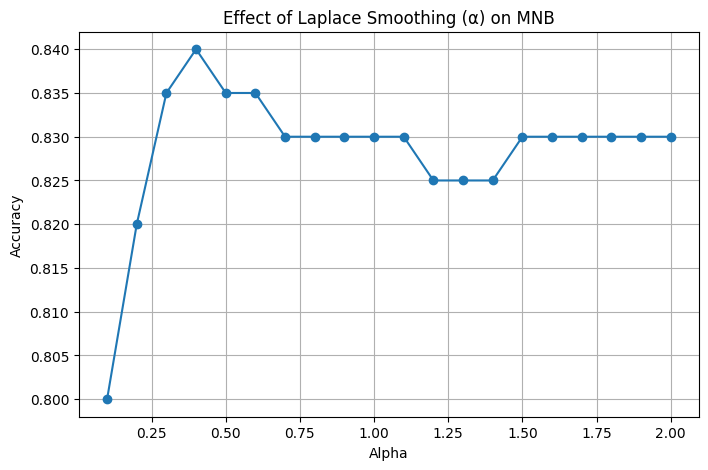

In [ ]:
############################
# NAIVE BAYES BOW TRAINING #
############################

# Observe the effect of alpha on accuracy
alpha_values = np.arange(0.1, 2.1, 0.1)
accuracies = []

for alpha in alpha_values:
    mnb = MultinomialNB(alpha=alpha)
    mnb.fit(X_train_bow, y_train)

    y_pred = mnb.predict(X_test_bow)
    acc = accuracy_score(y_test, y_pred)

    accuracies.append(acc)

plt.figure(figsize=(8, 5))
plt.plot(alpha_values, accuracies, marker='o')
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.title("Effect of Laplace Smoothing (α) on MNB")
plt.grid(True)
plt.show()


In [ ]:
alpha_bow = 0.4   # Set the smoothing parameter

mnb_bow = MultinomialNB(alpha=alpha_bow)  # Generate MNB, Laplace is done internally
mnb_bow.fit(X_train_bow, y_train)         # Learn the system (NB is a generative model)

y_pred_bow = mnb_bow.predict(X_test_bow)  # Predict the sentiments

print("MNB + Bag-of-Words Accuracy:", accuracy_score(y_test, y_pred_bow))
print(classification_report(y_test, y_pred_bow))

MNB + Bag-of-Words Accuracy: 0.84
              precision    recall  f1-score   support

           0       0.86      0.81      0.84       100
           1       0.82      0.87      0.84       100

    accuracy                           0.84       200
   macro avg       0.84      0.84      0.84       200
weighted avg       0.84      0.84      0.84       200



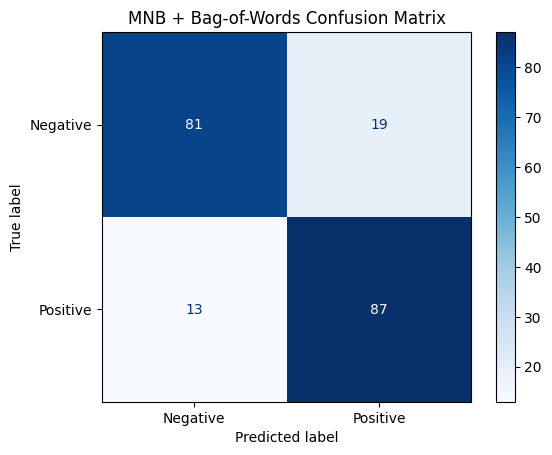

In [ ]:
cm_bow = confusion_matrix(y_test, y_pred_bow)

disp_bow = ConfusionMatrixDisplay(
    confusion_matrix=cm_bow,
    display_labels=["Negative", "Positive"]
)

disp_bow.plot(cmap="Blues")
plt.title("MNB + Bag-of-Words Confusion Matrix")
plt.show()


### Multinomial Naive Bayes with Tf-IDF

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)

# Learn the vocabulary and IDF weights from training data,
# then convert training text into TF-IDF feature vectors
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Convert test text using the same vocabulary and IDF weights
X_test_tfidf = tfidf_vectorizer.transform(X_test)


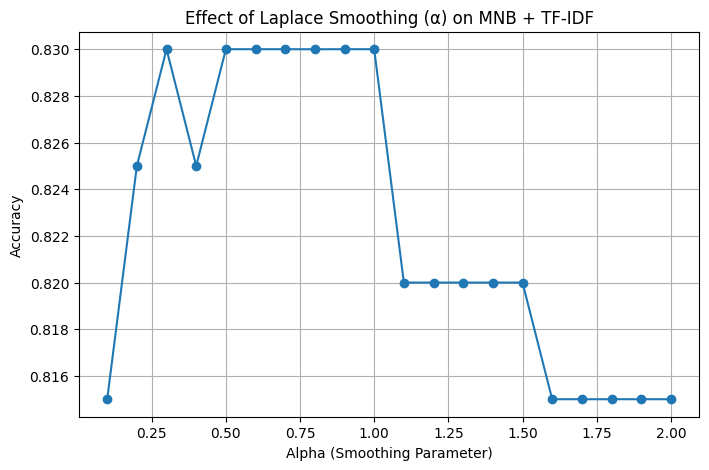

In [ ]:
tfidf_accuracies = []

for alpha in alpha_values:
    mnb = MultinomialNB(alpha=alpha)
    mnb.fit(X_train_tfidf, y_train)

    y_pred = mnb.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred)

    tfidf_accuracies.append(acc)

plt.figure(figsize=(8, 5))
plt.plot(alpha_values, tfidf_accuracies, marker='o')
plt.xlabel("Alpha (Smoothing Parameter)")
plt.ylabel("Accuracy")
plt.title("Effect of Laplace Smoothing (α) on MNB + TF-IDF")
plt.grid(True)
plt.show()


In [ ]:
mnb_tfidf = MultinomialNB(alpha=1)
mnb_tfidf.fit(X_train_tfidf, y_train)

y_pred_tfidf = mnb_tfidf.predict(X_test_tfidf)

print("MNB + TF-IDF Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print(classification_report(y_test, y_pred_tfidf))

MNB + TF-IDF Accuracy: 0.83
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       100
           1       0.82      0.84      0.83       100

    accuracy                           0.83       200
   macro avg       0.83      0.83      0.83       200
weighted avg       0.83      0.83      0.83       200



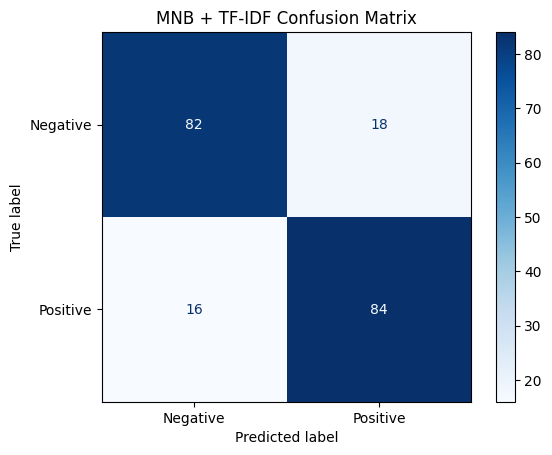

In [ ]:
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)

disp_tfidf = ConfusionMatrixDisplay(
    confusion_matrix=cm_tfidf,
    display_labels=["Negative", "Positive"]
)

disp_tfidf.plot(cmap="Blues")
plt.title("MNB + TF-IDF Confusion Matrix")
plt.show()


In [ ]:
# Helper function to collect false positives / false negatives
def collect_errors(X_test, y_test, y_pred, error_type, n=5):
    results = pd.DataFrame({
        "text": X_test.values,
        "true_label": y_test.values,
        "pred_label": y_pred
    })

    if error_type == "fp":
        errors = results[(results.true_label == 0) & (results.pred_label == 1)]
    elif error_type == "fn":
        errors = results[(results.true_label == 1) & (results.pred_label == 0)]
    else:
        raise ValueError("error_type must be 'fp' or 'fn'")

    return errors.head(n)["text"].reset_index(drop=True)


# Collect errors for both BoW and TF-IDF models
fp_bow   = collect_errors(X_test, y_test, y_pred_bow,   "fp", n=5)
fn_bow   = collect_errors(X_test, y_test, y_pred_bow,   "fn", n=5)

fp_tfidf = collect_errors(X_test, y_test, y_pred_tfidf, "fp", n=5)
fn_tfidf = collect_errors(X_test, y_test, y_pred_tfidf, "fn", n=5)


# Display condensed comparison tables
print("False Positives (Negative but Predicted Positive)")
display(pd.DataFrame({
    "BoW": fp_bow,
    "TF-IDF": fp_tfidf
}))

print("\nFalse Negatives (Positive but Predicted Negative)")
display(pd.DataFrame({
    "BoW": fn_bow,
    "TF-IDF": fn_tfidf
}))


False Positives (Negative but Predicted Positive)


,BoW,TF-IDF
0,graphics far best part game,graphics far best part game
1,sort pap screened afternoon punish unemployed jobs,sort pap screened afternoon punish unemployed jobs
2,unless youre visually collect extant films austens work skip one,unless youre visually collect extant films austens work skip one
3,find better movies youtube,find better movies youtube
4,gets simply theres nothing lower,gets simply theres nothing lower



False Negatives (Positive but Predicted Negative)


,BoW,TF-IDF
0,even sweet moments,even sweet moments
1,go rent,could used exemplars set designer
2,know gave,know gave
3,anne heche utterly convincing,anne heche utterly convincing
4,go watch,gave


## Logistic Regression with Pretrained Embeddings

So far, we have represented text using Bag-of-Words and TF-IDF, where each document is described by word frequencies. While these approaches are simple and effective, they treat words as independent symbols and do not capture semantic similarity between them.

In this section, we move to a more informative representation based on pretrained word embeddings, and combine it with Logistic Regression as a classifier.



### What Are Word Embeddings?

**Word embeddings** represent each word as a dense, low-dimensional vector learned from a large text corpus.  
Words with similar meanings tend to have similar vector representations.

For example:
- *good* and *great* will have vectors that are close to each other
- *movie* and *film* will be more similar than *movie* and *banana*

In this notebook, we use **pretrained embeddings** (e.g., GloVe or Word2Vec) that were trained on a very large external corpus. This way, we reuse semantic knowledge without training embeddings from scratch



### From Words to Document Vectors

Machine learning classifiers such as Logistic Regression require a **fixed-size input vector** for each document.  
Since documents contain a variable number of words, we need a way to aggregate word embeddings into a single document-level representation.

A simple and commonly used approach is average pooling.

For a document $d$ with words $w_1, w_2, \dots, w_n$, the document embedding is computed as:

$$
\mathbf{v}_d = \frac{1}{n} \sum_{i=1}^{n} \mathbf{e}(w_i)
$$

where $\mathbf{e}(w_i)$ is the embedding vector of word $w_i$.

This produces a dense vector of fixed dimension (e.g., 100), regardless of document length.



## Logistic Regression for Sentiment Classification

Once each document is represented by a dense embedding vector, we apply **Logistic Regression** to perform binary sentiment classification.


In the following cells, we will:
1. Load pretrained word embeddings
2. Construct document-level embedding vectors
3. Train a Logistic Regression classifier
4. Evaluate and compare its performance with previous methods


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-12-16 05:20:19--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-12-16 05:20:19--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-12-16 05:20:19--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [ ]:
def load_glove_embeddings(path):
    embeddings = {}
    with open(path, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            embeddings[word] = vector
    return embeddings


In [ ]:
glove_path = "glove.6B.100d.txt"   # 6 Billion tokens, 100-dimensional vectors
embeddings = load_glove_embeddings(glove_path)

embedding_dim = 100


In [ ]:
def sentence_embedding(sentence, embeddings, dim):
    vectors = [
        embeddings[word]              # Extract the embedding from GloVe set
        for word in sentence.split()  # for each word in the sentence
        if word in embeddings         # as long as the word has an embedding present in GloVe
    ]

    if len(vectors) == 0:
        return np.zeros(dim)

    return np.mean(vectors, axis=0)   # Return the average of word vectors as an aggregated sentence vector


In [ ]:
X_train_emb = np.vstack([
    sentence_embedding(s, embeddings, embedding_dim)
    for s in X_train
])     # Convert each review in the training set into a 100d vector.

X_test_emb = np.vstack([
    sentence_embedding(s, embeddings, embedding_dim)
    for s in X_test
])      # Do the same for the test set.


In [ ]:
logreg = LogisticRegression(
    max_iter=1000
)   # Create a Logistic Regression model

logreg.fit(X_train_emb, y_train)   # Train the model


LogisticRegression(max_iter=1000)

In [ ]:
y_pred_lr = logreg.predict(X_test_emb)  # Make predictions

print("LogReg + GloVe Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


LogReg + GloVe Accuracy: 0.81
              precision    recall  f1-score   support

           0       0.88      0.72      0.79       100
           1       0.76      0.90      0.83       100

    accuracy                           0.81       200
   macro avg       0.82      0.81      0.81       200
weighted avg       0.82      0.81      0.81       200



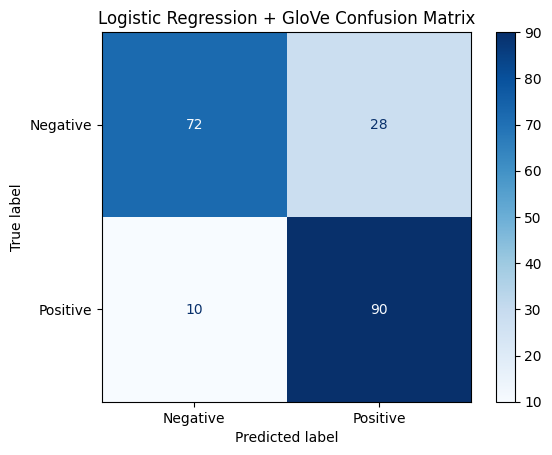

In [ ]:
cm_lr = confusion_matrix(y_test, y_pred_lr)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_lr,
    display_labels=["Negative", "Positive"]
)

disp.plot(cmap="Blues")
plt.title("Logistic Regression + GloVe Confusion Matrix")
plt.show()
